# Voting Behavior in Hungarian Parliament

## Motivation

The aim of the project is to analyze the network of relations between Hungarian parliament members according to their voting behavior. There is an extensive literature about the polarization of political parties in parliaments, a phonenomenon which refers to the divergence of political attitudes to ideological extremes. There is a belief that Hungarian MPs do not vote out of their fraction, and the results of the project will shed light on this issue from empirical point of view. This will help understand what is the actual relationship between the rhetoric and the actions of the parties. Besides, we will be able to identify the "separation" between existing parties. Now, in more detail about data. 
 
The data is obtained from the official website of the Hungarian Parliament (please, refer to https://www.parlament.hu/web/house-of-the-national-assembly for the website). It was web-scraped with the help of Beautiful Soup library in python, however, we do not include it into this notebook, as it is quite technical. However, it is appended to the submission files, in case you would like to see in more details how the data was scraped. The collected data:

 -  includes information on the current parliament, which was elected in April 2018, and it includes up untill the recent votes 
 -  contains voting information for 199 members of Parliament, however, since some members resigned due to multiple reasons and other took their place, the number of nodes is higher. It is worth mentioning that we dropped a few MPs, who were elected to Parliament, but voted only a few times (as they were strong outliers). 
 
We will construct a graph where each node represents one of the parliament members and edges are drawn every time two deputies display the same voting behavior (i.e. both vote in favor, against or abstain from vote). Then we will use modularity optimization to detect communities and compare this partition to the party division, drawing proper conclusions. 

Now, let's start the analysis itselt. We would like to first import the scraped data, clean and prepare it for the important calculations. 

*Before anything else, we need to import the libraries that are going to be used throughout the jupyter notebook. In addition to the standard libraries, we would also like to use networkx library which contains especially usefull function specifically for network analysis and community library, which is going to be helpful in comminity detection task.*

In [1]:
import pandas  as pd
import numpy as np
import networkx as nx
from tqdm import tqdm_notebook
import community
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(12,10), 'figure.dpi':120})

*Next step would be to import the file containing the scraped data. We would like to right away split the name of the parliament member and the party they associate themselves with. Next, we want to replace the NaNs with a space, as we plan to do operations afterwards with those values. We also rename one of the members, just because there are two members with exactly same name, and that is why we renamed one of them by adding the first letter of the party he belongs to. Finally, we set the name of the member as an index for our dataframe.*

In [2]:
df = pd.read_csv('df.csv')
df['Name'], df['Party'] = df['Unnamed: 0'].str.split('(', 1).str
df['Name'] = df['Name'].str.strip()
df['Party'] = df['Party'].str.replace(')', '').str.strip()
df.drop('Unnamed: 0', axis = 1, inplace=True)
df.replace(np.nan, '', inplace=True)
df.loc[12, 'Name'] = 'Bencsik János, F'
df = df.set_index('Name')
df.head()

,2018.05.11.10:30:28,2018.05.11.10:28:27,2018.05.11.10:27:40,2018.05.11.10:27:01,2018.05.11.10:26:27,2018.05.10.14:38:38,2018.05.10.14:36:59,2018.05.08.14:21:04,2018.05.08.14:20:21,2018.05.08.14:18:00,...,2019.11.18.15:18:06,2019.11.18.15:09:43,2019.11.18.15:00:42,2019.11.18.14:51:11,2019.11.18.14:43:03,2019.11.18.14:41:23,2019.11.18.14:35:05,2019.11.18.14:27:39,2019.11.18.14:23:12,Party
Name,,,,,,,,,,,,,,,,,,,,,
Ander Balázs,Igen,Nem,Nem,Nem,Nem,Nem,Igen,Igen,Igen,Igen,...,Nem,Nem,Nem,Nem,Igen,Igen,Igen,Igen,Igen,Jobbik
Arató Gergely,Igen,Nem,Nem,Nem,Nem,Nem,"Jelen, nem szav.",Nem szav.,Nem szav.,Nem szav.,...,Nem szav.,Nem szav.,Nem szav.,Nem szav.,Nem szav.,Nem szav.,Nem szav.,Nem szav.,Nem szav.,DK
B. Nagy László,Igen,Igen,Igen,Igen,Igen,Igen,Igen,Igen,Igen,Igen,...,Igen,Igen,Igen,Igen,Igen,Igen,Igen,Igen,Igen,Fidesz
Balczó Zoltán,,,,,,,,,,,...,Nem,Nem,Nem,Nem,Igen,Igen,Igen,Igen,Igen,Jobbik
Balla György,Igen,Igen,Igen,Igen,Igen,Igen,Igen,Igen,Igen,Igen,...,Igen,Igen,Igen,Igen,Igen,Igen,Igen,Igen,Igen,Fidesz


*The next step would be to get rid of the dublicates in the data, which is completed by the code below.*

In [3]:
col_list = list(df)
col_list_wout_party = col_list
col_list_wout_party.remove('Party')
agg_dict = {}
for col_l in col_list_wout_party: 
    agg_dict[col_l] = ''.join
agg_dict['Party'] = ', '.join
df = df.groupby('Name').agg(agg_dict)
#df[col_list_wout_party] = df[col_list_wout_party].replace(',', '')

*As mentioned in the beginning of the notebook we would like to delete those members that did not cast any votes or only a few of them, as they become strong outliers afterwards given that they do not contribute much to the analysis. Thus, it is safe to drop them.*

In [4]:
df.drop(['Ungár Péter Károly','Karácsony Gergely', 'Dr. Gémesi György', 'Janiczak Dávid', 'Dudás Róbert'], axis=0, inplace=True)

*What we would like to get is a dataframe, where the rows and columns of the data are the names of the parliament members, creating so-called adjacency matrix. For that we first create an empty matrix, so that then we add the weights*

In [5]:
names = df.index.tolist()
ad_df = pd.DataFrame(index=names, columns=names)
ad_df.replace(np.nan, 0, inplace=True)
ad_df.head()

,Ander Balázs,Arató Gergely,B. Nagy László,Balczó Zoltán,Balla György,Balla Mihály,Balog Zoltán,Bana Tibor,Bangóné Borbély Ildikó,Barcza Attila,...,Varga Mihály,Vargha Tamás,Varju László,Vigh László,Volner János,Vécsey László,Witzmann Mihály,Z. Kárpát Dániel,Zsigó Róbert,Ágh Péter
Ander Balázs,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Arató Gergely,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
B. Nagy László,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Balczó Zoltán,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Balla György,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


*Now, this is the central part of the analysis. We would like to now explain the method by which we calculated weights. Note, that each node represents one of the parliament members and edges are drawn every time two deputies display the same voting behavior (i.e. both vote in favor, against or abstain from vote). No edges are drawn for absent deputies. The code below does this calculation, adding appropriate numbers to the corresponding position in the matrix.*

In [6]:
df_values = df.values.tolist()
ad_df_list= ad_df.values.tolist()
i = 0
for name_1 in tqdm_notebook(df_values): 
    for j in range(len(name_1)):
        k = 0
        for name_2 in df_values: 
            if (name_1[j] in ['Igen','Nem', 'Tart.']) and (name_1[j]==name_2[j]): 
                ad_df_list[i][k] += 1
            k += 1 
    i +=1

In [7]:
ad_df_1 = pd.DataFrame(ad_df_list, columns=names, index=names)
#ad_df_1.to_csv('matrix.csv')

*To concert these number to weights, we need to normalize them, which is performed by the code below. Also, we would like to replace the diagonal values with 0, as we want to avoid creating unnecessary self-loops.*

In [8]:
#normalize & fill diagonal with 0 to avoid self-loops
ad=ad_df_1/len(df.columns)
np.fill_diagonal(ad.values, 0)
ad.head()

,Ander Balázs,Arató Gergely,B. Nagy László,Balczó Zoltán,Balla György,Balla Mihály,Balog Zoltán,Bana Tibor,Bangóné Borbély Ildikó,Barcza Attila,...,Varga Mihály,Vargha Tamás,Varju László,Vigh László,Volner János,Vécsey László,Witzmann Mihály,Z. Kárpát Dániel,Zsigó Róbert,Ágh Péter
Ander Balázs,0.000000,0.448574,0.224719,0.131374,0.227312,0.187554,0.090752,0.741573,0.507347,0.229041,...,0.150389,0.191011,0.456353,0.221262,0.592048,0.227312,0.233362,0.708729,0.227312,0.232498
Arató Gergely,0.448574,0.000000,0.112360,0.101988,0.114952,0.083838,0.029386,0.472774,0.474503,0.116681,...,0.056180,0.093345,0.544512,0.108038,0.363008,0.115817,0.117545,0.435609,0.114952,0.120138
B. Nagy László,0.224719,0.112360,0.000000,0.030251,0.932584,0.768366,0.225583,0.230769,0.160761,0.923077,...,0.529818,0.770959,0.114088,0.906655,0.242005,0.931720,0.917027,0.233362,0.924806,0.909248
Balczó Zoltán,0.131374,0.101988,0.030251,0.000000,0.031979,0.026793,0.000000,0.140017,0.087295,0.031979,...,0.016422,0.032844,0.095073,0.030251,0.062230,0.031979,0.034572,0.133103,0.031979,0.031979
Balla György,0.227312,0.114952,0.932584,0.031979,0.000000,0.769231,0.226448,0.233362,0.162489,0.977528,...,0.529818,0.825411,0.117545,0.962835,0.240277,0.987900,0.969749,0.235955,0.980985,0.962835


*Couple of dictionaries are created for the further use, i.e. for data manipulation.*

In [9]:
df_party=df.groupby('Party').size()
dict_party=df_party.to_dict()
dict_name=df["Party"].to_dict()

In [10]:
party_members={}
for key, value in dict_party.items():
    party_members[key]= df[df['Party']==key].index.tolist()

In [11]:
Party_names = list(party_members.values()) 
# we want to save the names of those members that are from Fidesz and KDNP parties, so that in future we can obtain only
# the names of the members from opposition parties. 
Fidesz_names=Party_names[2]
KDNP_names=Party_names[5]

### Analysis of party cohesions

#### Calculating intra-cluster density

Consider each party as a subgraph $C$ of the graph $G$, with  $n_C$ being the number of deputies in the party. An logical way of measuring party cohesion (i.e. the tendency of the party to vote as a single entity) is to evaluate the intra-cluster density.

It is defined as the ratio between the total internal strength of the sub-graph and the number of all possible edges inside that cluster:

$$d_{int} (C) = \frac {\sum_{ij\in C} w_{ij}} {n_C(n_C -1)/2}$$



In [12]:
for key,value in party_members.items():
    G=nx.from_pandas_adjacency(ad.loc[value][value])
    #print(nx.get_edge_attributes(G, 'weight'))
    print(key, nx.density(G))

DK 1.0
DK, független 0
Fidesz 0.9998551354483558
Jobbik 0.9430199430199431
Jobbik, független 1.0
KDNP 1.0
LMP 1.0
LMP, független 1.0
MSZP 1.0
Párbeszéd 1.0
Párbeszéd, független 1.0
nemzetiségi képviselő 0


The numbers support the common-sense wisdom, that hungarian MP-s hardly ever vote independently from their fraction: in the case of most parties, party members vote the same way all the time. There are no divisions in the parties.

#### Calculating inter-cluster density 

Similarly, we define the inter-cluster density $d_{ext}(C)$ as the ratio between the observed strength of edges running from the nodes of $C$ to the rest of the network and the maximum number of edges connecting internal with external nodes:

$$d_{ext}(C)= \frac {\sum_{i\in C , j\not\in C} w_{ij}} {n_C(n-n_C)}$$


Searching for the best tradeoff between a large intra-cluster density and a small inter-cluster one is indeed an implicit or explicit goal for most algorithms used in community detection. 

In [13]:
for key, value in party_members.items(): 
    members_of_other_parties = [member for member in list(ad) if member not in value] 
    weight_sum = 0
    for rep in value: 
        weight_sum += ad[rep][members_of_other_parties].sum()
    i_c_density = weight_sum/(len(value)*len(members_of_other_parties))
    print(key, i_c_density)

DK 0.1595976859231334
DK, független 0.17983821567327624
Fidesz 0.2644551221012848
Jobbik 0.19214656892559515
Jobbik, független 0.2215939139289901
KDNP 0.5382332872192683
LMP 0.1950969726418326
LMP, független 0.12611921749396965
MSZP 0.17044529674445405
Párbeszéd 0.20246113824184342
Párbeszéd, független 0.2378354449058752
nemzetiségi képviselő 0.4558030057648253


We see that parties connect to each other significantly less than within the parties. We see, that the most connected parties are Fidesz and KDNP, who have separate fraction in parliament, but govern in a very strong coalition, without any ideological difference. So their high inter clustering is explained by their coalition. 

#### Community detection

Modularity optimization is a well-established method for detecting communities. The idea behind modularity is that a random graph should not have a cluster structure so that communities are revealed maximizing the difference between the density of edges in a sub-graph and that expected if edges were connected at random. Hence the modularity function of a weighted graph, where in our case nodes are parliament members and edges represent the percentage of votes that two of them have in common, is given by:

$$Q=\frac{1}{2W}\sum_{i,j}(A_{ij}-\frac{s_i s_j}{2W}) \delta(C_i, C_j)$$, 

where $A_{ij}$ gives the fraction of similar votes parliament members $i$ and $j$ share in common ($A_{ij}=w{ij}$), $W$ os the total weight of the network, $\delta(C_i, C_j)$ is a delta function that yields on if members $i$ and $j$ are in the same community ($C_i=C_j$) and 0 otherwise, and $s_i, s_j$ represent the strength of node $i$ and $j$ respectively. 

In the code we use <font color=blue>best_partition</font> function, which computes the partition of the graph nodes by maximizing the modularity using the Louvain heuristices (refer here for details https://python-louvain.readthedocs.io/en/latest/api.html  ). 

C:\Users\Asus UX310\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


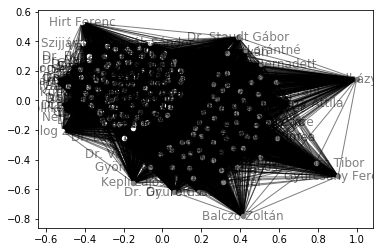

In [14]:
G=nx.from_pandas_adjacency(ad)
partition = community.best_partition(G)
size = float(len(set(partition.values())))
pos = nx.spring_layout(G)
count = 0.
for com in set(partition.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 20,
                                node_color = str(count / size))

nx.draw_networkx_labels(G, pos, alpha=0.5)
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()
nx.set_node_attributes(G, partition, "Partition")

From the graph we can see the optimal partition would be to divide into two cluters, however, the graph is not quite representative of the insights we would like to witness. We would like to export the network object and manipulat further with Gephi for obtaining eye pleasing graphs. Note, we save parties as an attribute, so that to compare the partition done by the algorithm and the present division based on parties. 

In [15]:
nx.set_node_attributes(G, dict_name, "Parties")
nx.write_gexf(G, "test.gexf")

We would also like to look at the partition when we include only opposition parties. For that we use the following code to only leave the names of the opposition members and then using the same algorithm we create a network object and export it for further improvement with Gephi.

In [16]:
ad_wtout_Fidesz=ad.drop(Fidesz_names, axis=0).drop(Fidesz_names, axis=1)
ad_wtout_Fidesz_KDNP=ad_wtout_Fidesz.drop(KDNP_names, axis=0).drop(KDNP_names, axis=1)

C:\Users\Asus UX310\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


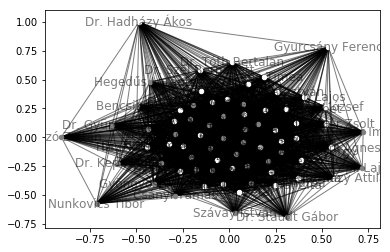

In [17]:
G1=nx.from_pandas_adjacency(ad_wtout_Fidesz_KDNP)
partition = community.best_partition(G1)
size = float(len(set(partition.values())))
pos = nx.spring_layout(G1)
count = 0.
for com in set(partition.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    nx.draw_networkx_nodes(G1, pos, list_nodes, node_size = 20,
                                node_color = str(count / size))

nx.draw_networkx_labels(G1, pos, alpha=0.5)
nx.draw_networkx_edges(G1, pos, alpha=0.5)
plt.show()
nx.set_node_attributes(G1, partition, "Partition")

In [18]:
nx.set_node_attributes(G1, dict_name, "Parties")
nx.write_gexf(G1, "test_Fidesz_KDNP.gexf")

In the following code we would like to calculate a couple of centrality measures for both network objects. 

#### Degree Centrality

In [28]:
from networkx.utils.decorators import not_implemented_for

degree_centrality_G=nx.degree_centrality(G)
degree_centrality_G1=nx.degree_centrality(G1)

#### Closeness Centrality

In [29]:
closeness_centrality_G = nx.closeness_centrality(G)
closeness_centrality_G1 = nx.closeness_centrality(G1)

#### Betweenness Centrality

In [30]:
betweenness_centrality_G = nx.betweenness_centrality(G)
betweenness_centrality_G1 = nx.betweenness_centrality(G1)

## Discussion 

It is evident from the results that indeed the belief that hungarian MPs don’t vote out of their fraction is justified. We witnessed those results both from the party cohesion analysis and the community detection. The significantly large intra-cluster density showed that Hungarian MP-s hardly ever vote independently from their fraction: in the case of most parties, party members vote the same way all the time, therefore there is no "separation" in the parties. Significantly low inter-cluster density in its turn indicated that parties connect to each other significantly less than within the parties, and the only parties that did have relatively higher value were Fidesz and KDNP, who have separate fraction in parliament, but govern in a very strong coalition, without any ideological difference. 

The community detections results (after manipulating with Gephi) indicated that in the first community detection, where all members were included, it divided into two partitions, which almost perfectly represented the governing parties vs opposition. The picture was less clear when governing parties' members were excluded from the analysis. 

These types of analysis are of great importance given that in modern parliamentary democracies the voting dynamics is often hidden by complicated voting procedures that prevent easy identification of these civil representatives.

## References 



Dal Maso, C., Pompa, G., Puliga, M., Riotta, G., & Chessa, A. (2014). *Voting behavior, coalitions and government strength through a complex network analysis.* PloS one, 9(12), e116046. doi:10.1371/journal.pone.0116046

Zhang, Xiao and Ma, Zhixin and Zhang, Ze and Sun, Qijuan and Yan, Jun. (2018). *A Review of Community Detection Algorithms Based on Modularity Optimization*. Journal of Physics: Conference Series, doi:10.1088/1742-6596/1069/1/012123

Zhou Z., Wang W., Wang L. (2012) *Community Detection Based on an Improved Modularity.* In: Liu CL., Zhang C., Wang L. (eds) Pattern Recognition. CCPR 2012. Communications in Computer and Information Science, vol 321. Springer, Berlin, Heidelberg